In [73]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score, StratifiedKFold,train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [74]:
df_fraud= pd.read_csv('Fraud_Data.csv')
df_ip = pd.read_csv('IpAddress_to_Country.csv')


### Part 1. Data Cleaning

First, I cleaned the data to prepare it for an exploratory data analysis and modeling. Before building any model to detect a fraud, I wanted to explore how each feature is related to the fraud. While cleaning my data, I did the following: 1) matched ip addresses with country names, 2) extracted day of the week (e.g., Monday, Tuesday) and month (e.g. January, February) from dates for signup time and purchase time, 3) extracted part of the day (Morning, Afternoon, Evening, and Night) for signup time and purchase time 4) estimated time-to-purchase in seconds by subtracting signup time from purchase time. 

I extracted month, day of the week, and part of the day to see whether fraudulet activities vary by month, day, and time and, also, to include those categorized variables into my machine learning model to avoid overfitting. 








In [75]:
from time import time
start = time()
def find_all_ip(ip):
    find = (ip <= df_ip['upper_bound_ip_address']) & ( ip >= df_ip['lower_bound_ip_address'])
    if find.any():
        return df_ip['country'][find].to_string(index=False)
    else:
        return 'Unknown'
df_fraud['country'] = df_fraud['ip_address'].apply(lambda x: find_all_ip(x))

print('used {:.2f}s'.format(time()-start))

used 559.84s


In [76]:
df_fraud['day_signup']= df_fraud['signup_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%a'))
df_fraud['month_signup']= df_fraud['signup_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%b'))
df_fraud['day_purchase']= df_fraud['purchase_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%a'))
df_fraud['month_purchase']= df_fraud['purchase_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%b'))
df_fraud['time_signup']= df_fraud['signup_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S'))
df_fraud['time_purchase']= df_fraud['purchase_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S'))

In [77]:
df_fraud['time_signup']=df_fraud['time_signup'].apply(lambda x: x.replace('00','24',2))
def get_day_part(time_sign_up):
        return (
        "Morning" if 6 < time_sign_up <= 12
        else
        "Afternoon" if 12 < time_sign_up <= 18
        else
        "Evening" if 18 < time_sign_up <= 24
        else
        "Night")
df_fraud['signup_day_part']=df_fraud['time_signup'].map(lambda x: int(x[:2])).map(get_day_part)

In [78]:
df_fraud['time_purchase']=df_fraud['time_purchase'].apply(lambda x: x.replace('00','24',2))
def get_day_part(time_purchase):
        return (
        "Morning" if 6 < time_purchase <= 12
        else
        "Afternoon" if 12 < time_purchase <= 18
        else
        "Evening" if 18 < time_purchase <= 24
        else
        "Night")
df_fraud['purchase_day_part']=df_fraud['time_purchase'].map(lambda x: int(x[:2])).map(get_day_part)

In [79]:
df_fraud['purchase_time']= df_fraud['purchase_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'));
df_fraud['signup_time']= df_fraud['signup_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'));
df_fraud['time_to_purchase']=df_fraud['purchase_time']-df_fraud['signup_time'];
df_fraud['time_to_purchase'] = df_fraud['time_to_purchase'].apply(lambda x: x.seconds)
df_fraud['Fraud']=df_fraud['class'].apply(lambda x: 'Yes' if x==1 else 'No')

### Part 2. Exploratory Data Analysis

Next, I conducted an exploratory data analysis by analyzing how each feature (predictor) relates to fraud. 

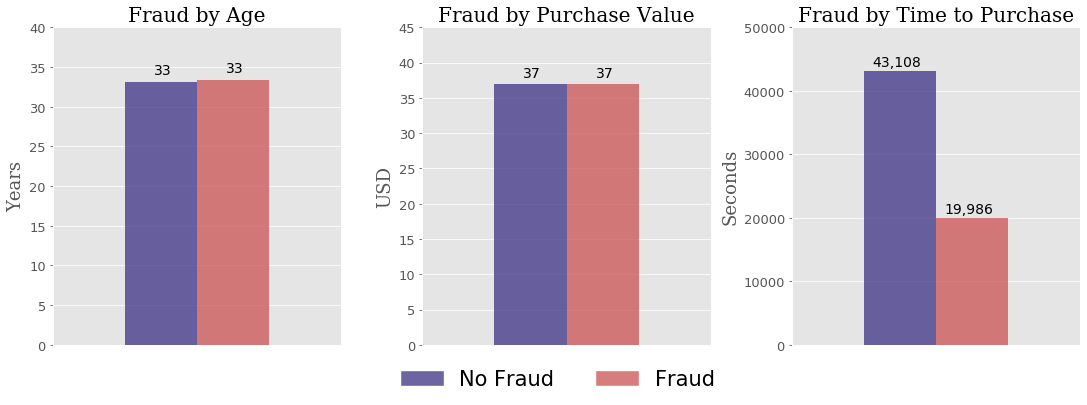

In [80]:
plt.style.use('ggplot')

fig, axes = plt.subplots(ncols=3, figsize=(15,5))
plt.tight_layout(w_pad=5)
cont=['age','purchase_value','time_to_purchase']
titles=['Age','Purchase Value','Time to Purchase']
for ax,feature, title in zip(axes.flat,cont, titles):
    df=df_fraud.groupby(['Fraud']).agg({feature: 'mean'}).T.reset_index()
    df[['No','Yes']].plot(kind='bar',
               color=['darkslateblue','indianred'],\
                              fontsize=13, alpha=.8, ax=ax)
    ax.set_xticks([])
    leg=ax.legend().set_visible(False)
    if feature=='age':
        ax.set_ylim([0,40])
        ax.set_ylabel('Years',size =18,family='serif')
        
        for i in ax.patches:
            ax.text( i.get_x()+.1,i.get_height()+1, \
                '{:.0f}'.format(i.get_height()), fontsize=14)
    elif feature=='purchase_value':
        ax.set_ylim([0,45])
        ax.set_ylabel('USD',size =18,family='serif')
        for i in ax.patches:
            ax.text( i.get_x()+.1,i.get_height()+1, \
                '{:.0f}'.format(i.get_height()), fontsize=14)
    else:
        ax.set_ylim([0,50000])
        ax.set_ylabel('Seconds',size =18,family='serif')
        for i in ax.patches:
            ax.text( i.get_x()+.03,i.get_height()+800, \
                '{:,.0f}'.format(i.get_height()), fontsize=14)
    ax.set_title('Fraud by '+ title ,fontsize=20,family='serif')
leg=ax.legend(['No Fraud','Fraud'],  ncol=2,loc='lower right', \
          fontsize=12,prop={'size':21},bbox_to_anchor=(-.2, -.2))
leg.legendHandles[1].set_color('indianred')
leg.legendHandles[0].set_color('darkslateblue')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show()        
        
    


As we can see from the bar charts above, on average, fraud did not vary by age and purchase value. However, there was a difference in fraudulent activities by time-to-purchase. People who were likely to commit a fraud, on average, spent much less time between creating an account and buying an item (19,986 secs vs. 43,108 secs). 

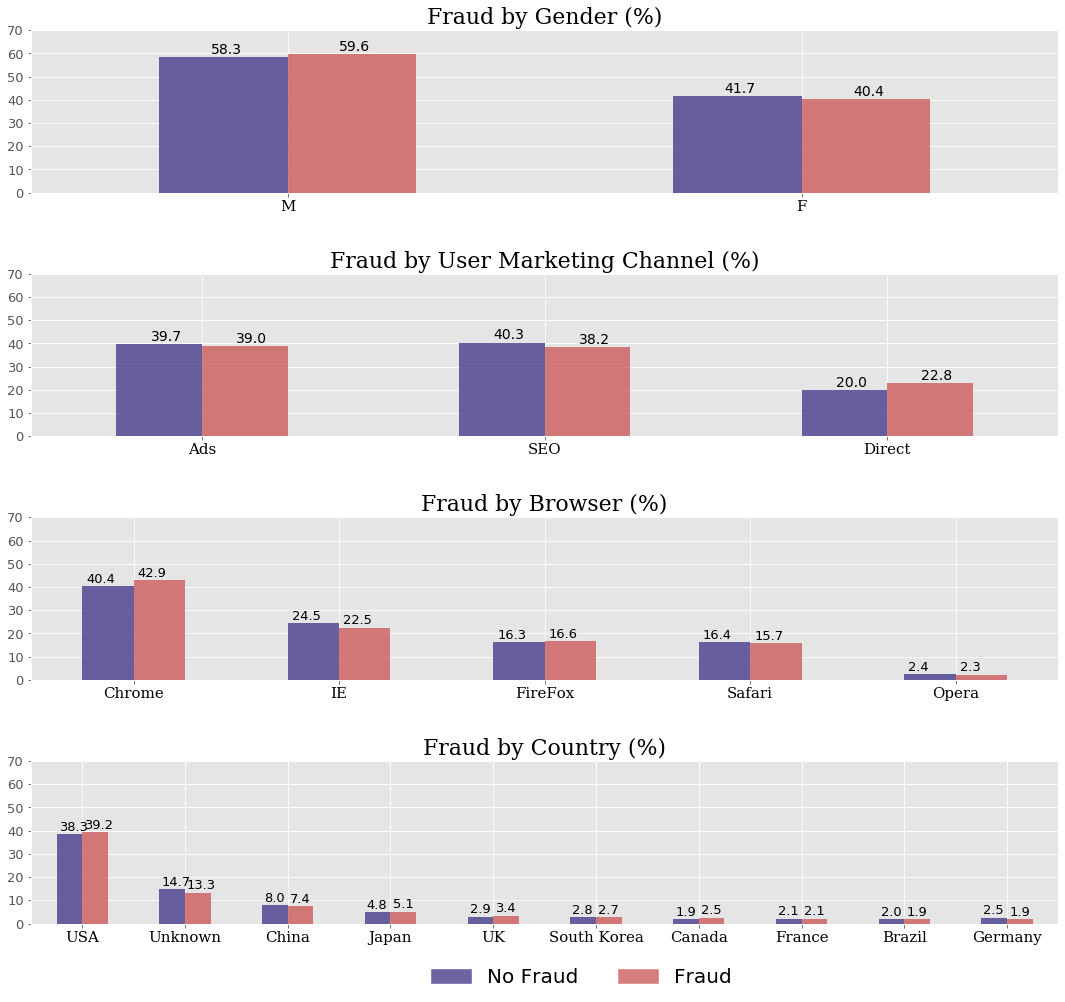

In [81]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=4, figsize=(15,13))
plt.tight_layout(h_pad=6)
cat=['sex','source','browser','country']
titles=['Gender','User Marketing Channel','Browser','Country']
for ax,feature, title in zip(axes.flat,cat, titles):
    df1=df_fraud.groupby(['Fraud',feature]).agg({'user_id': 'count'})
    df2= df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()

    df3=pd.pivot_table(df2, index=['Fraud'], values=['user_id'], \
                   columns=feature,aggfunc='mean').T.reset_index().iloc[:,1:].\
                   sort_values(by='Yes',ascending=False)
    df3[['No','Yes']][:10].plot(kind='bar',
               color=['darkslateblue','indianred'],\
                              fontsize=13, alpha=.8, ax=ax)
    
    leg=ax.legend().set_visible(False)
    ax.set_title('Fraud by '+ title +' (%)' ,fontsize=22,family='serif')
    ax.set_ylim([0,70])
    if feature=='country' or feature=='browser':
        for i in ax.patches:
            ax.text( i.get_x()+.02,i.get_height()+1.5, \
                '{:.1f}'.format(i.get_height()), fontsize=13)
    else:
        for i in ax.patches:
            ax.text( i.get_x()+.1,i.get_height()+1.5, \
                '{:.1f}'.format(i.get_height()), fontsize=14)
        

    if feature=='country':
        ax.set_xticklabels(['USA','Unknown','China','Japan','UK',\
                            'South Korea','Canada','France','Brazil','Germany'],size =15,family='serif', \
                       color='black', rotation='horizontal')

    else:
        ax.set_xticklabels(df3[feature],size =15,family='serif', \
                       color='black', rotation='horizontal')
leg=ax.legend(['No Fraud','Fraud'],  ncol=2,loc='lower right', \
          fontsize=12,prop={'size':20},bbox_to_anchor=(.70, -.5))
leg.legendHandles[1].set_color('indianred')
leg.legendHandles[0].set_color('darkslateblue')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show()     

There were slight variations in fraud activities by gender. However, I am not sure whether gender is a reliable predictor as it seems to me that someone who wants to commit a fraud will not report his/her real gender and age. I don’t know how the age and gender were collected (this info is not given to me) but I can assume they were self-reported.  

A fraud was more likely to be conducted over direct user marketing channel using chrome browser. Slightly more fraud activities were coming from the USA, although, ip addresses can be traced so I don’t know if all ip addresses in this data set are legit.    


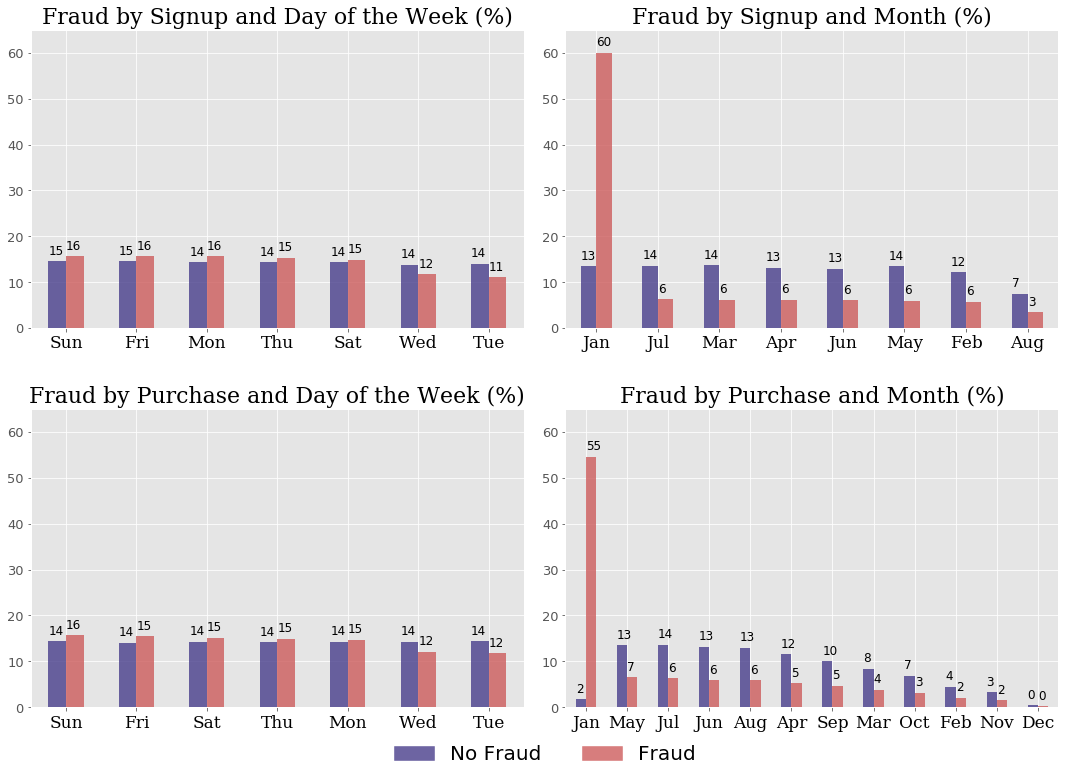

In [82]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,10))
plt.tight_layout(h_pad=6)
cat=['day_signup','month_signup','day_purchase','month_purchase']
titles=['Signup and Day of the Week','Signup and Month',\
        'Purchase and Day of the Week','Purchase and Month']
for ax,feature, title in zip(axes.flat,cat, titles):
    df1=df_fraud.groupby(['Fraud',feature]).agg({'user_id': 'count'})
    df2= df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()

    df3=pd.pivot_table(df2, index=['Fraud'], values=['user_id'], \
                   columns=feature,aggfunc='mean').T.reset_index().iloc[:,1:].\
                   sort_values(by='Yes',ascending=False)
    df3[['No','Yes']].plot(kind='bar',
               color=['darkslateblue','indianred'],\
                              fontsize=13, alpha=.8, ax=ax)
    
    leg=ax.legend().set_visible(False)
    ax.set_title('Fraud by '+ title+' (%)' ,fontsize=22,family='serif')
    for i in ax.patches:
        ax.text( i.get_x()+.001,i.get_height()+1.5, \
                '{:.0f}'.format(i.get_height()), fontsize=12)
    ax.set_ylim([0,65])
    ax.set_xticklabels(df3[feature],size =17,family='serif', \
                       color='black', rotation='horizontal')
leg=ax.legend(['No Fraud','Fraud'],  ncol=2,loc='lower right', \
          fontsize=12,prop={'size':20},bbox_to_anchor=(.3, -.25))
leg.legendHandles[1].set_color('indianred')
leg.legendHandles[0].set_color('darkslateblue')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show() 

There were slightly more fraudulent activities taking place on weekends (Sunday and Saturday) and Friday, but those differences were very minor. Most importantly, January is the month when the most fraudulent activities were taking place (around 60%). I think that is a very important finding which can help improve the prediction accuracy. 

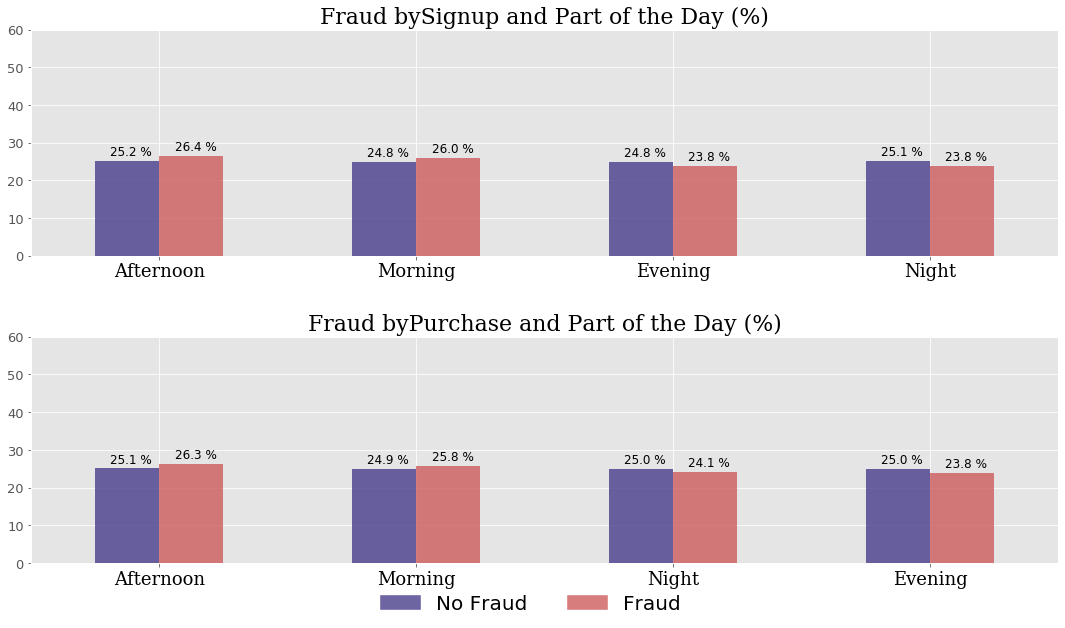

In [83]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=2,figsize=(15,8))
plt.tight_layout(h_pad=6)
cat=['signup_day_part','purchase_day_part']
titles=['Signup and Part of the Day','Purchase and Part of the Day']
for ax,feature, title in zip(axes.flat,cat, titles):
    df1=df_fraud.groupby(['Fraud',feature]).agg({'user_id': 'count'})
    df2= df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()

    df3=pd.pivot_table(df2, index=['Fraud'], values=['user_id'], \
                   columns=feature,aggfunc='mean').T.reset_index().iloc[:,1:].\
                   sort_values(by='Yes',ascending=False)
    df3[['No','Yes']].plot(kind='bar',
               color=['darkslateblue','indianred'],\
                              fontsize=13, alpha=.8, ax=ax)
    
    leg=ax.legend().set_visible(False)
    ax.set_title('Fraud by'+ title +' (%)' ,fontsize=22,family='serif')
    for i in ax.patches:
        ax.text( i.get_x()+.06,i.get_height()+1.5, \
                '{:.1f} %'.format(i.get_height()), fontsize=12)
    ax.set_ylim([0,60])
    ax.set_xticklabels(df3[feature],size =18,family='serif', \
                       color='black', rotation='horizontal')

leg=ax.legend(['No Fraud','Fraud'],  ncol=2,loc='lower right', \
          fontsize=12,prop={'size':20},bbox_to_anchor=(.65, -.3))
leg.legendHandles[1].set_color('indianred')
leg.legendHandles[0].set_color('darkslateblue')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show() 

It looks like there were slightly more fraudulent activities during the morning and afternoon than during the evening and nights.

### Part 3. Machine Learning Model


To build machine learning model, I excluded the following features: age, gender, and device id. I included purchase value, time to purchase, source, browser, country, day of the week for signups and purchases, month of signups and purchases, day parts of signups and purchases. Why did I exclude age, gender, and device id but included country? I excluded age and gender because they might be inaccurately reported by people who are committing the fraud. Also, age and gender were not adding any predictive value to the model. I excluded device ids because even though it might predict the fraud, including it can overfit the model as device ids can change in the long run. 

I included country, however. It did improve slightly accuracy on my model and worked very well with a synthetic minority oversampling technique (SMOT) and Random Forest so I decided to keep country as my predictor. 



I picked ensembles for the models (Random Forest, Ada Boost, and Gradient Boosting) because they work well with synthetic minority oversampling techniques for imbalanced outcomes. There are much less fraudulent activities in the data set (approximately 10%), which means that will significantly reduce accuracy of the predictive model, and specifically, the accuracy of recall. Thus, I, first, trained my models without an oversampling and then with a synthetic oversampling to see whether it can improve the accuracy of one of the ensembles.


In [84]:
from sklearn.preprocessing import StandardScaler
X_norm =  StandardScaler().fit_transform(df_fraud[['purchase_value','time_to_purchase']]);
df_cont=pd.DataFrame(X_norm,columns=['purchase_value','time_to_purchase'])
len(df_cont)

151112

In [85]:
import patsy
patsy_matrix = patsy.dmatrix('~ C(source) +C(browser)+C(country)+\
C(day_signup) + C(month_signup)+C(day_purchase)+C(month_purchase)+\
C(signup_day_part)+C(purchase_day_part)', df_fraud)

df_cat=pd.DataFrame(patsy_matrix, columns=patsy_matrix.design_info.column_names)
len(df_cat)

151112

In [86]:
df_combined = pd.concat([df_cont, df_cat], axis=1)
len(df2)

8

In [87]:
X=df_combined
y=df_fraud['class'].values

In [88]:
df_fraud['class'].value_counts(normalize=True)

0    0.906354
1    0.093646
Name: class, dtype: float64

Random Forest Score:	0.956 ± 0.001
Ada Boost Score:	0.957 ± 0.001
Gradient Boosting Score:	0.957 ± 0.001

Feature Weights:


,Random Forest,Ada Boost,Gradient Boosting
time_to_purchase,0.994071,0.14,0.209472
purchase_value,0.000730,0.04,0.085782
C(source)[T.Direct],0.000488,0.02,0.010144
C(day_purchase)[T.Sun],0.000259,0.02,0.011651
C(country)[T. Algeria],0.000226,0.02,0.000646
C(month_purchase)[T.Jan],0.000206,0.02,0.097608
C(country)[T. Turkmenistan],0.000205,0.02,0.000040
C(month_signup)[T.Mar],0.000196,0.00,0.011488
C(day_purchase)[T.Mon],0.000189,0.02,0.010976
C(month_signup)[T.Jan],0.000176,0.00,0.098296


None


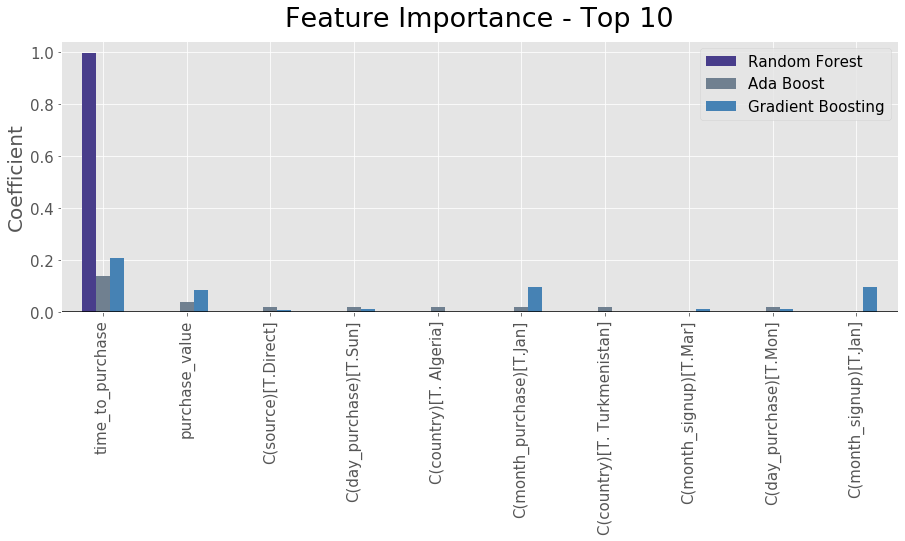

In [89]:
plt.style.use('ggplot')

X_train, X_test, y_train, y_test = train_test_split(X,\
                                                    y,train_size=0.7,random_state=1,stratify=y)

rf = RandomForestClassifier(random_state=10,class_weight = 'balanced')
abc = AdaBoostClassifier(random_state=10)
gbc = GradientBoostingClassifier(random_state=10)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=78)
def score(model, name):
    s = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))


score(rf,"Random Forest")
score(abc, "Ada Boost")
score(gbc, "Gradient Boosting")


rf.fit(X_train, y_train)
abc.fit(X_train, y_train)
gbc.fit(X_train, y_train)


importances = pd.DataFrame(list(zip(gbc.feature_importances_,
                               abc.feature_importances_,
                               rf.feature_importances_,
                              )),
                           index=X_train.columns,
                           columns=['Random Forest',
                                    'Ada Boost',
                                    'Gradient Boosting',
                                   ]).sort_values('Random Forest',
                                                                 ascending=False)

print ()
print ('\033[1m'+'Feature Weights:'+'\033[0m')
print (display(importances.head(30)))



importances[0:10].plot(kind='bar', figsize=(15,5), color=['darkslateblue','slategrey','steelblue',])


plt.title('Feature Importance - Top 10', fontsize = 27, y = 1.03, color='black')


plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)
plt.axhline(0, color='black')
plt.xticks(rotation=90, fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

Above are the feature weights of the training set estimated by Random Forest vs. Ada Boost vs. Gradient Boosting. The most dominant feature is time-to-purchase, followed by purchase value and source. Radom Forest seems to give the highest weight to time-to-purchase. Let’s see how it is going to change after applying a synthetic oversampling. 

In [90]:
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
matrix_clf = np.array(confusion_matrix(y_test, rf.predict(X_test)))
confusion_clf = pd.DataFrame(matrix_clf, index=['No Fraud','Fraud'],\
                     columns=['No Fraud','Fraud'])
print('Test Accuracy: %.2f%%' % (100 * test_acc))
print ('')
print (classification_report(y_test, y_pred_test))

Test Accuracy: 95.66%

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.54      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



We can see that in spite of high accuracy scores, fraud recall is only 54% but precision is 100%. Let’s see whether a synthetic oversampling can improve the recall without significantly undermining the precision. Note: all models gave me identical confusion matrices. I picked Random Forest though as it is faster than boosting, less impacted by noise (it is pretty stable), and robust to outliers.  

In [91]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind='regular')
X_resampled, y_resampled = sm.fit_sample(X, y)


Random Forest SMOT Score:	0.97 ± 0.001
Ada Boost SMOT Score:	0.896 ± 0.001
Gradient Boosting SMOT Score:	0.946 ± 0.002

Feature Weights:


,Random Forest SMOT,Ada Boost SMOT,Gradient Boosting SMOT
time_to_purchase,0.314221,0.02,0.160856
C(month_purchase)[T.Jan],0.185668,0.02,0.131596
C(country)[T. United States],0.083638,0.10,0.040255
C(source)[T.SEO],0.039656,0.08,0.018351
C(source)[T.Direct],0.034765,0.10,0.018469
C(browser)[T.IE],0.028242,0.08,0.022543
C(browser)[T.Safari],0.023667,0.04,0.016371
C(browser)[T.FireFox],0.022356,0.10,0.016717
C(day_purchase)[T.Mon],0.020562,0.08,0.015295
C(country)[T.Unknown],0.017632,0.06,0.010682


None


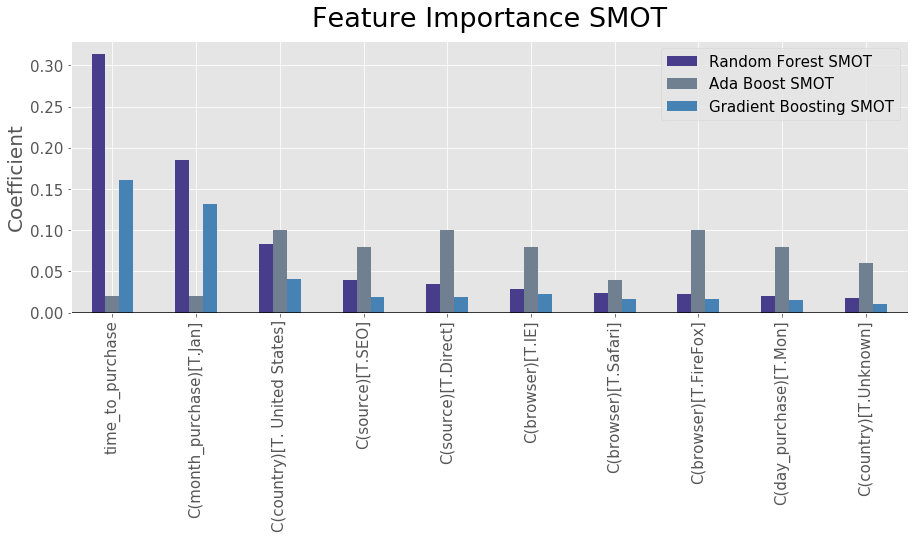

Time used 1452.61s


In [92]:
from time import time
start = time()

plt.style.use('ggplot')

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled,\
                                                    y_resampled,train_size=0.7,random_state=1,stratify=y_resampled)

rf_smote = RandomForestClassifier(random_state=10,class_weight = 'balanced')
abc_smote = AdaBoostClassifier(random_state=10)
gbc_smote = GradientBoostingClassifier(random_state=10)

cv_smote = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
def score(model, name):
    s = cross_val_score(model, X_train_smote, y_train_smote, cv=cv_smote, n_jobs=-1)
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))


print ()
score(rf_smote,"Random Forest SMOT")
score(abc_smote, "Ada Boost SMOT")
score(gbc_smote, "Gradient Boosting SMOT")


rf_smote.fit(X_train_smote, y_train_smote)
abc_smote.fit(X_train_smote, y_train_smote)
gbc_smote.fit(X_train_smote, y_train_smote)


importances = pd.DataFrame(list(zip(gbc_smote.feature_importances_,
                               abc_smote.feature_importances_,
                               rf_smote.feature_importances_,
                              )),
                           index=X_train.columns,
                           columns=['Random Forest SMOT',
                                    'Ada Boost SMOT',
                                    'Gradient Boosting SMOT',
                                   ]).sort_values('Random Forest SMOT',
                                                                 ascending=False)


print ()
print ('\033[1m'+'Feature Weights:'+'\033[0m')
print (display(importances.head(30)))

importances[0:10].plot(kind='bar', figsize=(15,5), color=['darkslateblue','slategrey','steelblue',])
plt.title('Feature Importance SMOT', fontsize = 27, y = 1.03, color='black')
plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)
plt.axhline(0, color='black')
plt.xticks(rotation=90, fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

print('Time used {:.2f}s'.format(time()-start))

We can see how feature weights have changed after applying SMOT. Time-to- purchase still has more weight than any other feature, however, it does not dominate the model anymore. Month of January is the second largest predictor of fraud, followed by country (USA) and source (SEO and Direct). Those weights are more in correspondence with the results of the exploratory data analysis, in which I found those features being related to increased fraudulet activities.  

In [93]:
test_acc = accuracy_score(y_true=y_test, y_pred=rf_smote.predict(X_test))
matrix_clf_smote = np.array(confusion_matrix(y_test, rf_smote.predict(X_test)))
confusion_clf_smote = pd.DataFrame(matrix_clf_smote, index=['No Fraud','Fraud'],\
                     columns=['No Fraud','Fraud'])
print('Test Accuracy: %.2f%%' % (100 * test_acc))
print ('')
print (classification_report(y_test, y_pred_test_smote))

Test Accuracy: 98.20%

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41089
           1       0.99      0.81      0.89      4245

    accuracy                           0.98     45334
   macro avg       0.99      0.91      0.94     45334
weighted avg       0.98      0.98      0.98     45334



Applying SMOT to Radom Forest increased fraud recall by 50% but decreased model’s precision by .0001%. I believe it is a very good trade off, considering that the recall is significantly improved. Let’s compare the results of two confusion matrices. 

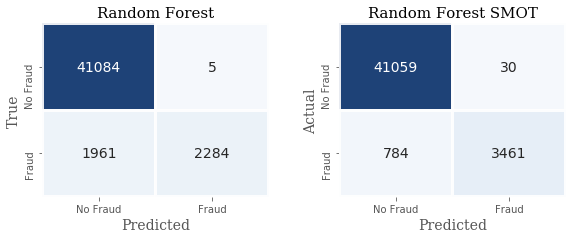

In [94]:
# from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.style.use(['ggplot'])

fig, axes = plt.subplots(1,2, figsize=(8,3))
plt.tight_layout(w_pad=4.0)


sns.heatmap(confusion_clf, annot=True, annot_kws={"size": 14},cmap="Blues",fmt='g', cbar=False,linewidths=2,ax=axes[0], alpha=.9)
axes[0].set_ylabel('True', fontsize=14,family='serif')
axes[0].set_xlabel('Predicted', fontsize=14,family='serif')
axes[0].set_title("Random Forest", fontsize=15, y=1.05,family='serif')

sns.heatmap(confusion_clf_smote, annot=True, annot_kws={"size": 14},cmap='Blues',fmt='g', cbar=False,linewidths=2,ax=axes[1], alpha=.9)
axes[1].set_ylabel('Actual', fontsize=14,family='serif')
axes[1].set_xlabel('Predicted', fontsize=14,family='serif')
axes[1].set_title("Random Forest SMOT", fontsize=15, y=1.05,family='serif')

plt.show()

It looks like recall is significantly improved by recalling (1,961–792) 1,169 additional fraudulent activities. However, because SMOT decreased the model's precision a bit, we can see that it identified more non-fraudulent activities as fraud (44-5=39). I think this is a very good result. Depending on how model is used, applying Random Forest with SMOT can be a good alternative model.


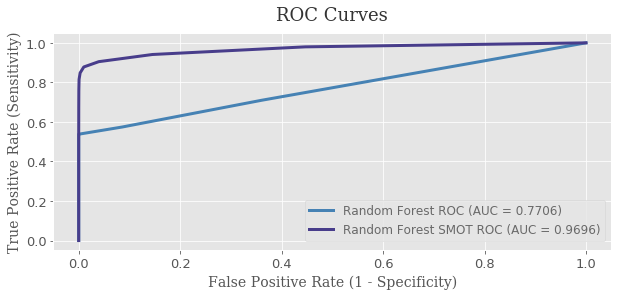

In [116]:

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


plt.style.use('ggplot')

plt.figure(figsize=(10,4))

y_pred_clf = rf.predict_proba(X_test)[:,1]
y_pred_clf_smote = rf_smote.predict_proba(X_test)[:,1]


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_clf)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test,y_pred_clf_smote)


ROC_AUC = auc(fpr, tpr)
ROC_AUC1 = auc(fpr1, tpr1)


plt.plot(fpr, tpr, label='Random Forest ROC (AUC = %0.4f)' % ROC_AUC,color='steelblue', linewidth=3)
plt.plot(fpr1, tpr1, label='Random Forest SMOT ROC (AUC = %0.4f)' % ROC_AUC1, color='darkslateblue',linewidth=3)


# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14,family='serif')
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=14,family='serif')


l=plt.legend(loc='lower right', fontsize=12,bbox_to_anchor=(1, 0.015))
for text in l.get_texts():
    text.set_color("dimgray")

plt.title('ROC Curves', color="black", alpha=0.8,fontsize=18, y=1.03,family='serif')
plt.show()

Finally, as we can see above, the ROC curve is also significantly improved by applying a synthetic oversampling technique to Random Forest. 

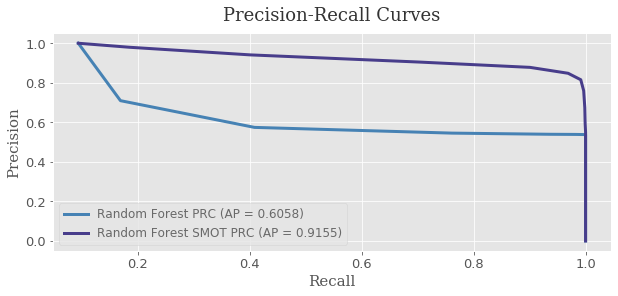

In [118]:
from sklearn.metrics import average_precision_score

plt.style.use('ggplot')

plt.figure(figsize=(10,4))

y_pred_clf = rf.predict_proba(X_test)[:,1]
y_pred_clf_smote = rf_smote.predict_proba(X_test)[:,1]

precision, tpr, thresholds = metrics.precision_recall_curve(y_test, y_pred_clf)
precision1, tpr1, thresholds1 = metrics.precision_recall_curve(y_test,y_pred_clf_smote)

average_precision=average_precision_score(y_test, y_pred_clf)
average_precision1=average_precision_score(y_test,y_pred_clf_smote)

plt.plot(precision, tpr, label='Random Forest PRC (AP = %0.4f)' % average_precision,color='steelblue', linewidth=3)
plt.plot(precision1, tpr1, label='Random Forest SMOT PRC (AP = %0.4f)' % average_precision1, color='darkslateblue',linewidth=3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
l=plt.legend(loc='lower left', fontsize=12)
for text in l.get_texts():
    text.set_color("dimgray")

plt.xlabel('Recall', fontsize=15,family='serif')
plt.ylabel('Precision',fontsize=15,family='serif')
plt.title('Precision-Recall Curves', color="black", alpha=0.8,fontsize=18, y=1.03,family='serif')
plt.show()    

I also explored Precision-Recall curves since, there are many arguments in the scientific filed that they deliver better performance measure when there is an imbalanced outcome. As we can see above, the average precision is much higher for SMOT Random Forest, confirming ROC and AUC results. 